In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rasterio
import statsmodels.api as sm

from scipy.special import inv_boxcox
from scipy import stats
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

<Axes: >

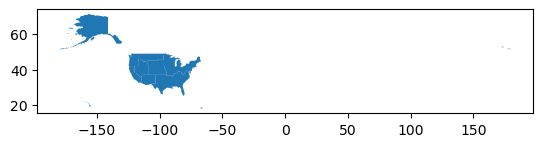

In [2]:
regionsUSFS_shp = gpd.read_file('Shapefiles/S_USA.AdministrativeRegion/S_USA.AdministrativeRegion.shp')
regionsUSFS_shp.plot()

<Axes: >

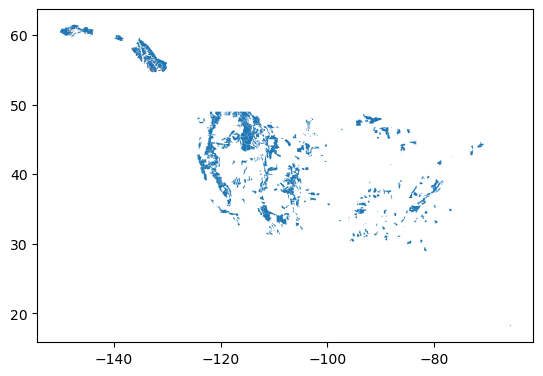

In [3]:
forestsUSFS_shp = gpd.read_file('Shapefiles/S_USA.AdministrativeRegion/S_USA.AdministrativeForest.shp')
forestsUSFS_shp.plot()

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import ProbPlot
from pmdarima import auto_arima

In [5]:
# Read in data and remove any lingering commas
timberDf = pd.read_csv('/Users/louisgoodall/Desktop/Timber Data.csv')
cleanCols = ['Year','Quarter','Sold_Volume_MBF','Sold_Volume_CCF',
            'Sold_Value','Sold_per_MBF','Sold_per_CCF','Cut_Volume_MBF',
            'Cut_Volume_CCF','Cut_Value']
for col in cleanCols:
    timberDf[col] = timberDf[col].astype(str).str.replace(',', '', regex=False)
timberDf[cleanCols] = timberDf[cleanCols].astype(float)

# Long to wide, then recalculate the quarterly values. Original format has the quarterly
# values as cumulative
df  = timberDf.pivot(index=['National_Forest', 'Year', 'Species', 'Product'], columns='Quarter', values='Sold_Value').reset_index()
# df = df.drop(columns=np.nan)
df.rename(columns={1.0:'Q1', 2.0:'Q2', 3.0:'Q3', 4.0:'Q4'}, inplace=True)
df = df.replace(np.nan, 0)
df = df.assign(Q2 = df['Q2'] - df['Q1'],
               Q3 = df['Q3'] - df['Q2'],
               Q4 = df['Q4'] - df['Q3'])
df[['Q1','Q2','Q3','Q4']] = df[['Q1','Q2','Q3','Q4']].clip(lower=0)
df = df.assign(Total = df['Q2'] + df['Q3'] + df['Q4'] + df['Q1']) # Anything Quarterly value < 0 is now 0

# Back to long format and add columns that can be used for plotting/in a model
df = pd.melt(df, id_vars=['National_Forest', 'Year', 'Species'], value_vars=['Q1','Q2','Q3','Q4'], value_name='Sold_Value')
df['Year'] = df['Year'].astype(int)
df['Quarter'] = df['Quarter'].astype(str)
df['YearQuarter'] = df['Year'].astype(str) + df['Quarter']
df['Quarter'] = pd.PeriodIndex(df['YearQuarter'], freq='Q').to_timestamp()
df['Quarter_Num'] = df['YearQuarter'].str.split('Q').str[1].astype(int)
df['Numeric_Quarter'] = df['Year'] + (df['Quarter_Num'] - 1) / 4
df

,National_Forest,Year,Species,Quarter,Sold_Value,YearQuarter,Quarter_Num,Numeric_Quarter
0,Columbia River Gorge,2010,Douglas-fir,2010-01-01,189110.25,2010Q1,1,2010.00
1,Columbia River Gorge,2010,Douglas-fir,2010-01-01,0.00,2010Q1,1,2010.00
2,Columbia River Gorge,2011,Douglas-fir,2011-01-01,0.00,2011Q1,1,2011.00
3,Columbia River Gorge,2011,Western Hemlock,2011-01-01,0.00,2011Q1,1,2011.00
4,Columbia River Gorge,2012,Douglas-fir,2012-01-01,0.00,2012Q1,1,2012.00
...,...,...,...,...,...,...,...,...
5943,Willamette,2016,Western Hemlock,2016-10-01,0.00,2016Q4,4,2016.75
5944,Willamette,2016,Western Red Cedar,2016-10-01,0.00,2016Q4,4,2016.75
5945,Willamette,2016,Western Red Cedar,2016-10-01,0.00,2016Q4,4,2016.75
5946,Willamette,2016,Western Red Cedar,2016-10-01,40.00,2016Q4,4,2016.75


# Total Harvest
This will serve as a template for the other models that I will deploy. More data is still needed to create fully functioning time series models

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/var/folders/9b/6_fqcsbn0gj7ftczc3760qlr0000gn/T/ipykernel_40676/3454461185.py:22: SyntaxWarning: invalid escape sequence '\s'
  plot_lm_3.axes[0].set_ylabel('$\sqrt{Standardized Residuals}$')


Text(0, 0.5, '$\\sqrt{Standardized Residuals}$')

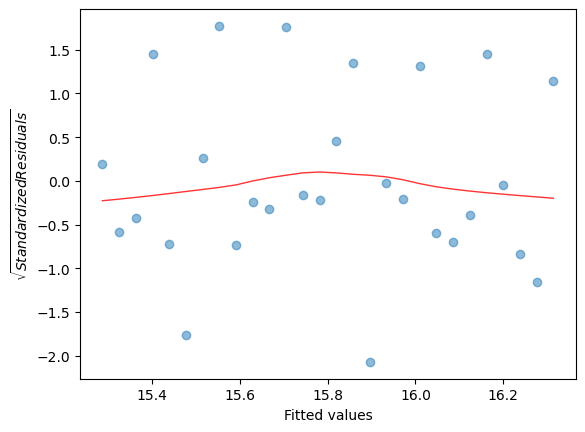

In [6]:
# Create total harvest dataframe and X/y objects then model
totalHarvestDf = df.groupby(['Numeric_Quarter'])[['Sold_Value']].agg('sum').reset_index()
totalHarvestDf['log'] = np.log(totalHarvestDf['Sold_Value'])
# totalHarvestDf = totalHarvestDf.iloc[:-1] # used to remove the last row which is 0 in log, uncomment if all quarters present
X = totalHarvestDf['Numeric_Quarter']
y = totalHarvestDf['log']
model = sm.OLS(y, sm.add_constant(X))
model_fit = model.fit()

# Plot standardised residuals vs. fitted values
plotDf = pd.concat([X, y], axis=1)
normalisedResiduals = model_fit.get_influence().resid_studentized_internal
fittedValues = model_fit.fittedvalues
plot_lm_3 = plt.figure()
plt.scatter(fittedValues, normalisedResiduals, alpha=0.5)
sns.regplot(x=fittedValues, y=normalisedResiduals,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{Standardized Residuals}$')

In [7]:
totalHarvestDf

,Numeric_Quarter,Sold_Value,log
0,2010.00,5154410.78,15.455363
1,2010.25,2761388.49,14.831244
2,2010.50,3254452.38,14.995535
3,2010.75,17125018.65,16.656051
4,2011.00,2722220.18,14.816958
5,2011.25,1132556.74,13.939988
6,2011.50,6872118.19,15.742983
7,2011.75,27113517.23,17.115543
8,2012.00,3082225.68,14.941163
9,2012.25,4942753.29,15.413433


Text(0.5, 0, 'Quarter')

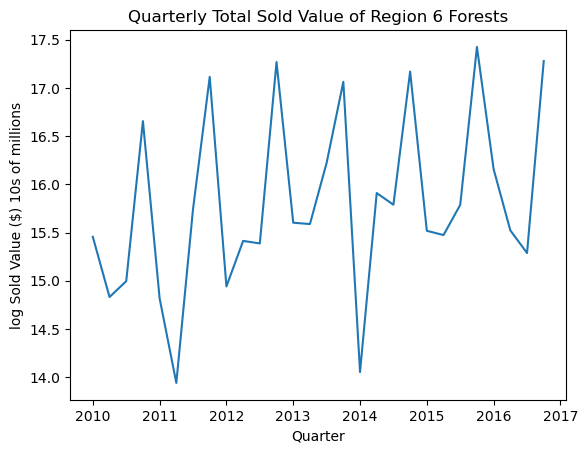

In [8]:
# Check out pattern of total sold value
sns.lineplot(totalHarvestDf, x='Numeric_Quarter', y='log')
plt.title('Quarterly Total Sold Value of Region 6 Forests')
plt.ylabel("log Sold Value ($) 10s of millions")
plt.xlabel('Quarter')

In [9]:
# Test the stationarity of the differenced y variable using the ADF test
# We did good
totalHarvestDf['valueDiff'] = totalHarvestDf['Sold_Value'].diff()
totalHarvestDf['logDiff'] = totalHarvestDf['log'].diff() # May not need later on
result = adfuller(totalHarvestDf['log'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Summary of SARIMAX output
# TEST FOR NOW, NEED TO CHECK REGULAR ARIMA TOO
train = totalHarvestDf[:int(0.8*(len(totalHarvestDf)))]
test = totalHarvestDf[int(0.8*(len(totalHarvestDf))):]
train = train[['Numeric_Quarter', 'log']]
model = SARIMAX(train['log'], order=(0,0,0), seasonal_order=(1,1,1,4))
result = model.fit()
result.summary()

ADF Statistic: -1.3227687366028251
p-value: 0.6186922908147148


/opt/anaconda3/envs/DS/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                       log   No. Observations:                   22
Model:             SARIMAX(1, 1, [1], 4)   Log Likelihood                 -16.986
Date:                   Sun, 04 May 2025   AIC                             39.973
Time:                           21:12:47   BIC                             42.644
Sample:                                0   HQIC                            40.341
                                    - 22                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L4       -0.5910      0.412     -1.436      0.151      -1.398       0.216
ma.S.L4       -0.0689      0.542     -0.127      0.899      -1.132       0.994
sigma2         0.3448      0.157      2.192      0.028       0.036       0.653
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 0.79
Prob(Q):                              0.67   Prob(JB):                         0.67
Heteroskedasticity (H):               0.84   Skew:                            -0.48
Prob(H) (two-sided):                  0.84   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
model = ARIMA(train['log'], order=(0,0,0))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    log   No. Observations:                   22
Model:                          ARIMA   Log Likelihood                 -29.303
Date:                Sun, 04 May 2025   AIC                             62.605
Time:                        21:13:14   BIC                             64.787
Sample:                             0   HQIC                            63.119
                                 - 22                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.6798      0.197     79.660      0.000      15.294      16.066
sigma2         0.8403      0.300      2.802      0.005       0.252       1.428
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                 0.35
Prob(Q):                              0.49   Prob(JB):                         0.84
Heteroskedasticity (H):               1.16   Skew:                             0.14
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

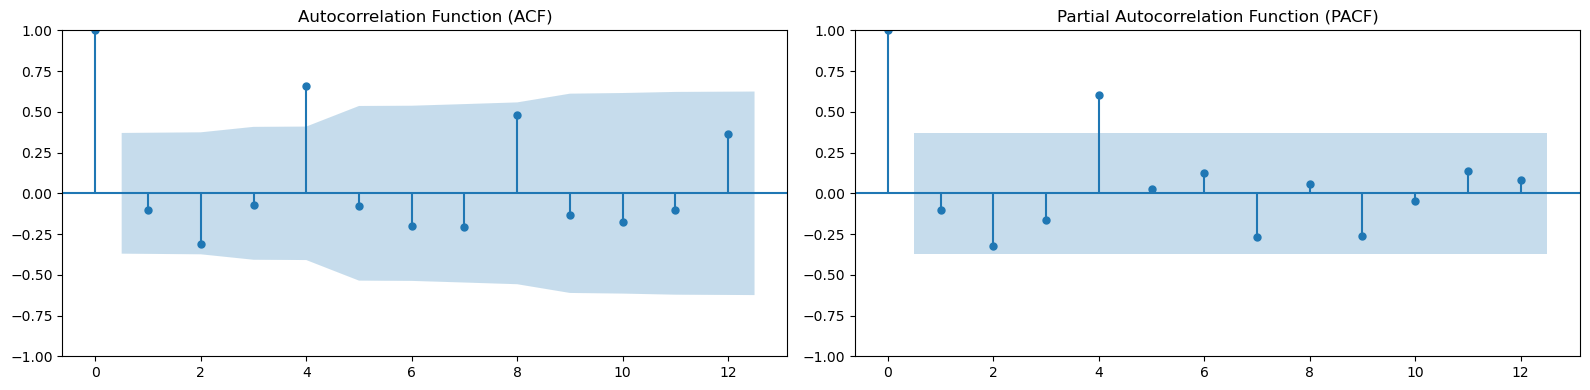

In [15]:
# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(totalHarvestDf['log'].dropna(), lags=12, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(totalHarvestDf['log'].dropna(), lags=12, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

count    22.000000
mean     15.679819
std       0.938249
min      13.939988
25%      15.093436
50%      15.553079
75%      16.144663
max      17.269450
Name: log, dtype: float64

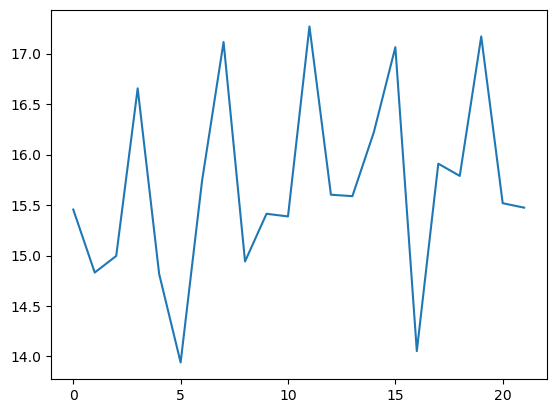

In [16]:
train['log'].plot()
train['log'].describe()

In [17]:
x = auto_arima(train['log'], start_p=1, start_q=1, seasonal=False)
x.summary()

/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will b

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   22
Model:                        SARIMAX   Log Likelihood                 -29.303
Date:                Sun, 04 May 2025   AIC                             62.605
Time:                        21:14:34   BIC                             64.787
Sample:                             0   HQIC                            63.119
                                 - 22                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     15.6798      0.197     79.661      0.000      15.294      16.066
sigma2         0.8403      0.300      2.802      0.005       0.252       1.428
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                 0.35
Prob(Q):                              0.49   Prob(JB):                         0.84
Heteroskedasticity (H):               1.16   Skew:                             0.14
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""